# Alzheimer prediction using gray matter density from T1w MRI 

**Deadline**: Upload this notebook (rename it as 'TP4-Trees-YOUR-SURNAME.ipynb') with your answers and code to the Moodle/Ecampus before the deadline.


We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier



In [2]:
# from google_drive_downloader import GoogleDriveDownloader as gdd
# gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
# dest_path='./dataTP.npz')
# gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
# dest_path='./AtlasAAL2.nii')
# gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
# dest_path='./AtlasAICHA.nii')
# gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
# dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas  
    y = data['y'] # classes, 0 for controls and 1 for patients    
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2 
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA 
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS         

In [3]:
# Choose Atlas (here AAL2)
X=T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

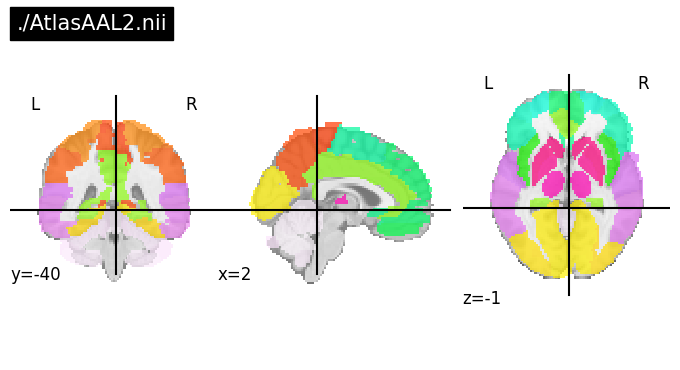

In [4]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [5]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used. 

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training. 

Min and Max values of the data are respectively: 0.0 and 0.885043542362


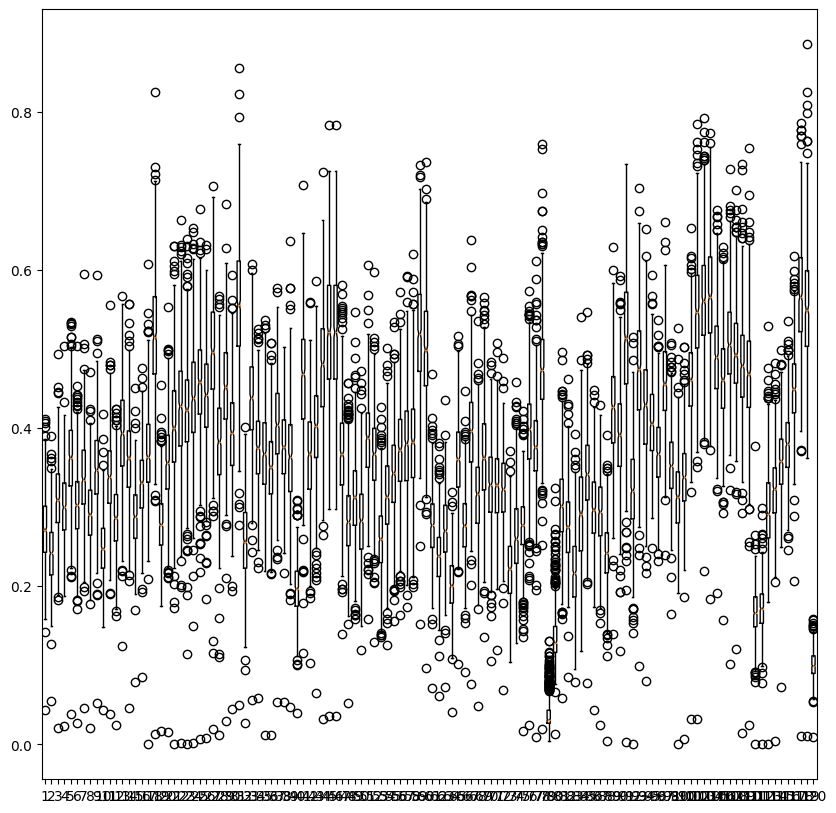

In [6]:
plt.figure(figsize=(10,10))
plt.boxplot(X,notch=True)

print( 'Min and Max values of the data are respectively: {0} and {1}'.format(np.min(X_train), np.max(X_train)))

# Standardization/Normalization

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# #normalization
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


Then, we can fit a Decision tree, with the default setting, using the following code:

In [7]:
# Fitting Decision Trees 
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.7606382978723404


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ? 


**Answer** : 
the best value is 2 for min_samples_split and 3 for min_samples_leaf for test set with this state. For the training set, the more min_samples_split/min_samples_leaf the worse the score is. If we split differently the data, the best value for min_samples_split and min_samples_leaf can change with the test set a lot. 

The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  2


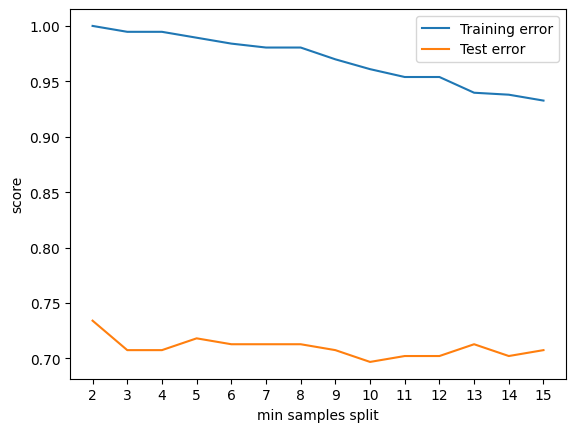

In [8]:
# min_samples_split

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=42)
    Tree.fit(X_train, y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test,y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  13


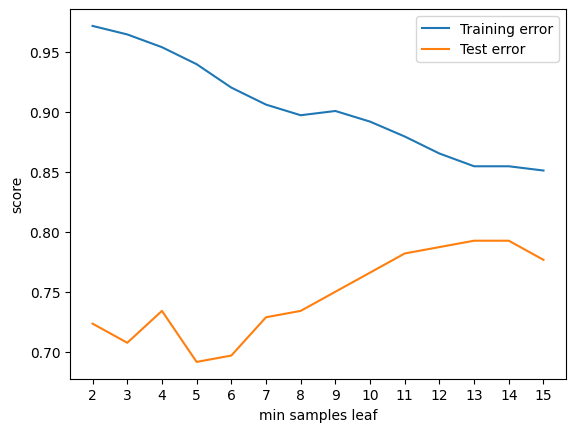

In [9]:
# min_samples_leaf
TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=42)
    Tree.fit(X_train, y_train)
    scoreTrain=Tree.score(X_train,y_train)
    scoreTest=Tree.score(X_test,y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training error')
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test error')
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples leaf')
plt.ylabel('score')
print("The value of min_samples_leaf that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

Try to add Gaussian noise to the data (using for instance zero mean and 0.05 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise. 

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

**Answer**: The results are not stable. The score can change a lot with the noise.

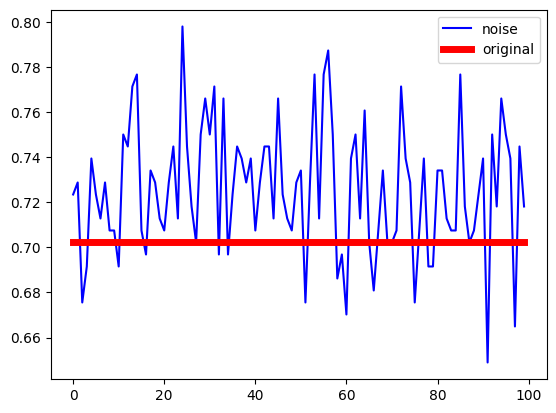

In [10]:
Tree = DecisionTreeClassifier(min_samples_split=2,min_samples_leaf=3,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train,y_train)
scoreTest[:] = Tree.score(X_test,y_test)

for k in range(100):    
    X_train_temp=np.copy(X_train)
    for i in range(X_train.shape[0]):
        X_train_temp[i] = X_train[i] + np.random.normal(0,0.05,X_train.shape[1])
        
    Tree.fit(X_train_temp,y_train)
    scoreTestnoise[k] = Tree.score(X_test,y_test)
    
plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')       
plt.legend();

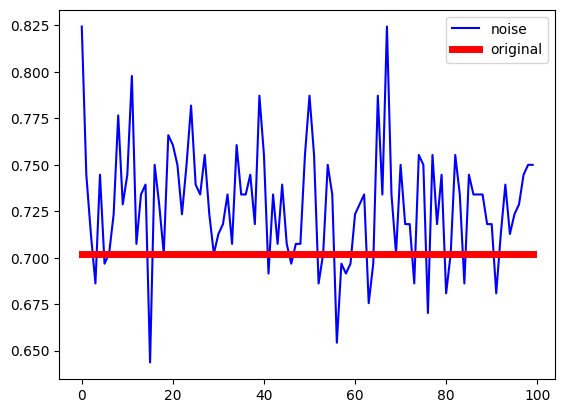

In [11]:
Tree = DecisionTreeClassifier(min_samples_split=2,min_samples_leaf=3,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train,y_train)
scoreTest[:] = Tree.score(X_test,y_test)

for k in range(100):    
    X_train_temp=np.copy(X_train)
    for i in range(X_train.shape[0]):
        X_train_temp[i] = X_train[i] + np.random.normal(0,0.05,X_train.shape[1])
        
    Tree.fit(X_train_temp,y_train)
    scoreTestnoise[k] = Tree.score(X_test,y_test)
    
plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')       
plt.legend();

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*. 
 

First plot the tree learnt on the original data, witout adding noise.

In [17]:
import graphviz 

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph.render()

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

**Answer**: The trees are not the same. The tree learnt on noisy data is deeper and has more nodes. The more noise we add, the deeper the tree is.

In [16]:
X_train_temp = np.copy(X_train)
for i in range(X_train.shape[0]):
  X_train_temp[i] = np.random.normal(X_train_temp[i], 0.05)

Tree.fit(X_train_temp, y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way. 

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

**Answer:** We find the same min_samples_split but not the same min_samples_leaf. It's logical to find different hyperparameters because we try to optimize the best couple of hyperparameters.

**Answer:**  I would use 'balanced_accuracy' because it is better for imbalanced data.

In [20]:
Tree = DecisionTreeClassifier(random_state=2)
p_grid_tree = {'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 'min_samples_leaf': [2,3,4,5,6,7,8,9,10,11,12,13,14,15]} 

grid_tree = GridSearchCV(estimator=Tree, param_grid=p_grid_tree, scoring='balanced_accuracy', cv=5)
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test,y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.7561599040625078
Best params: {'min_samples_leaf': 12, 'min_samples_split': 2}
Tree test score : 0.7816746022529323


Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library. 

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

**Answer:** The order of the features is not exactly the same, but the same features are found at the top of both trees, showing their importance.

In [23]:
Tree = DecisionTreeClassifier(min_samples_split=best_params['min_samples_split'],min_samples_leaf=best_params['min_samples_leaf'],random_state=0)
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. 

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ?

**Answer:**  We find the same  best validation score which shows that the algorithm is robust. The best bagging test score is find with the noisy data. However, the n_estimators is larger with the noisy data which is logical since we need more weak classifiers to compensate that the data varies a lot.

In [24]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring='balanced_accuracy', cv=5)
grid_bagging.fit(X_train, y_train.ravel())
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test.ravel()))

c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWar

Best Validation Score: 0.8080459914511303
Best params: {'n_estimators': 15}
Bagging test score : 0.7609453025200326


In [25]:
# Bagging on noisy data
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring='balanced_accuracy', cv=5)
grid_bagging.fit(X_train_temp, y_train.ravel())
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test.ravel()))

c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWar

Best Validation Score: 0.8079459302738302
Best params: {'n_estimators': 20}
Bagging test score : 0.7943328301010335


The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [26]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring= 'balanced_accuracy', cv=5)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

Best Validation Score: 0.8248362889068087
Best params: {'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 20}
Random Forest test score : 0.7644292184415282


Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging. 

In [27]:
# Random Forest on noisy data
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring= 'balanced_accuracy', cv=5)
grid_RF.fit(X_train_temp, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

Best Validation Score: 0.8180752002220568
Best params: {'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 30}
Random Forest test score : 0.7327836488212751


We can also use Random Forests to check the importance of the features

c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Feature ranking:
1. feature 44 representing 45 Amygdala_L 4201
 (0.066954)
2. feature 43 representing 44 ParaHippocampal_R 4112
 (0.065684)
3. feature 45 representing 46 Amygdala_R 4202
 (0.054810)
4. feature 40 representing 41 Hippocampus_L 4101
 (0.050583)
5. feature 92 representing 93 Temporal_Inf_L 8301
 (0.034649)
6. feature 93 representing 94 Temporal_Inf_R 8302
 (0.027087)
7. feature 41 representing 42 Hippocampus_R 4102
 (0.023602)
8. feature 59 representing 60 Fusiform_R 5402
 (0.022711)
9. feature 42 representing 43 ParaHippocampal_L 4111
 (0.021267)
10. feature 86 representing 87 Temporal_Pole_Sup_L 8121
 (0.020576)


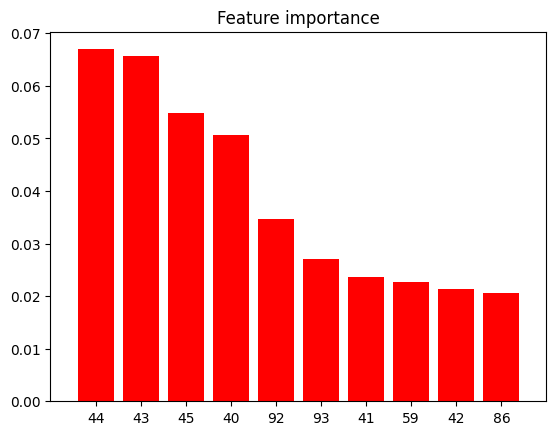

In [28]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense. 

**Answer**: The most important features are Amygdala_L 4201, ParaHHippocampus, and hippocampus. 

It is said in the article that 'Among recent studies, Tang et al. (2016) used volumetric, shape, and diffusion features of the hippocampus and amygdala for AD classification' so our results make sense.

We can also inspect the data using only pairs of the most important features

c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1152: DataConversionW

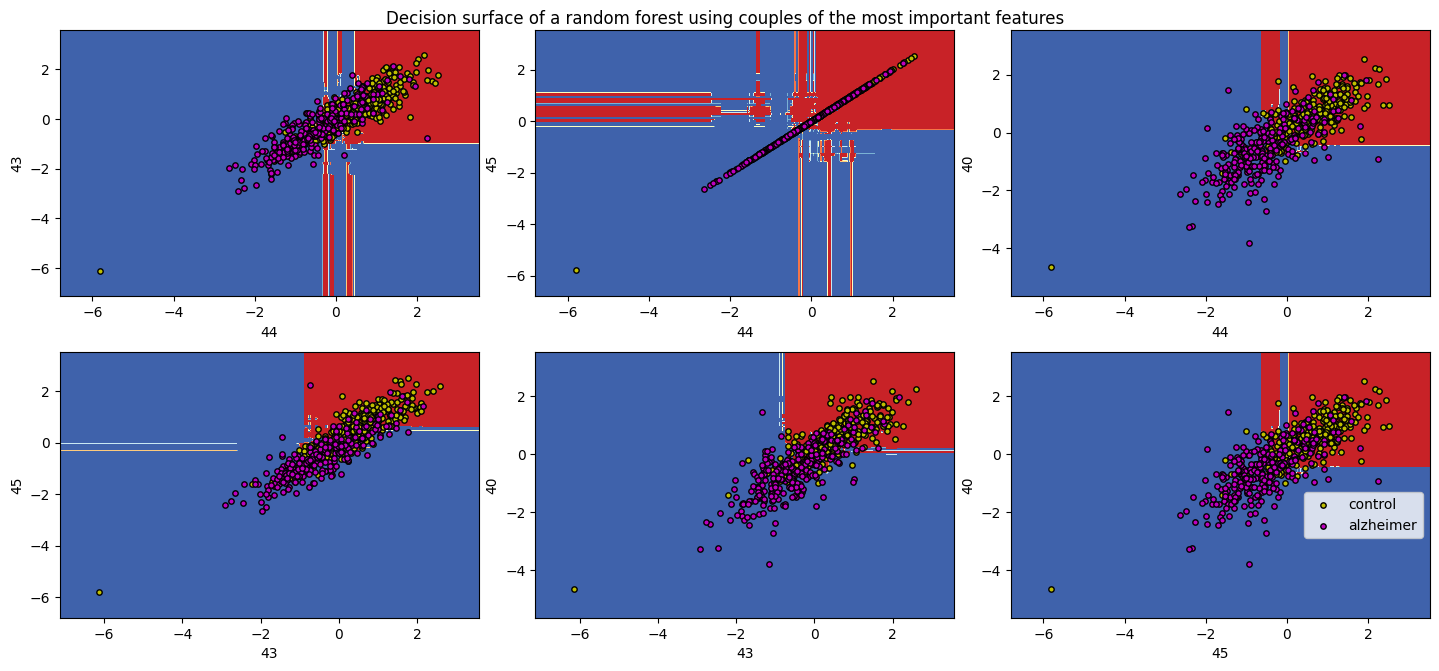

In [29]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question**: Which is the best couple of features ?

**Answer**: The best couple of features is 45 and 43. There's a large proportion of purple data in the the blue region and most of the yellow points are in the red region. 

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

**Answer** : By changing the atlas we change the region that are considered as important. The most important features are different.

In the article it is said that : 

The features of each region were analyzed with a random forest classifier to extract the relevant ones, which were subsequently processed with SVM for prediction of AD conversion. Recently, Tang et al. (2015) used shape diffeomorphometry of the left and right amygdala, hippocampus, thalamus, caudate, putamen, globus pallidus, and lateral ventricle for prediction of AD conversion using LDA


AD affects brain regions well beyond the hippocampus, such as atrophy of the entorhinal cortex, expansion of the ventricle, and volumetric changes in other subcortical nuclei (amygdala, putamen,caudate, and thalamus) 

The ROIs depends a lot of the random_state but we see that the thalamus, the Caudate and the Parietooccipital are often found in the most important features.  
Regarding this article, my results makes sense.

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 192
Best Validation Score: 0.750810134863291
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 30}
Random Forest test score : 0.6600000000000001
Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.051526)
2. feature 173 representing 174	N_Caudate-1	175
 (0.039293)
3. feature 186 representing 187	N_Thalamus-4	188
 (0.037300)
4. feature 187 representing 188	N_Thalamus-5	189
 (0.035237)
5. feature 74 representing 75	G_Insula-anterior-3	76
 (0.030516)
6. feature 170 representing 171	G_Fusiform-6	172
 (0.024292)
7. feature 172 representing 173	N_Amygdala-1	174
 (0.020668)
8. feature 188 representing 189	N_Thalamus-6	190
 (0.017591)
9. feature 189 representing 190	N_Thalamus-7	191
 (0.017295)
10. feature 94 representing 95	G_Temporal_Inf-2	96
 (0.016280)


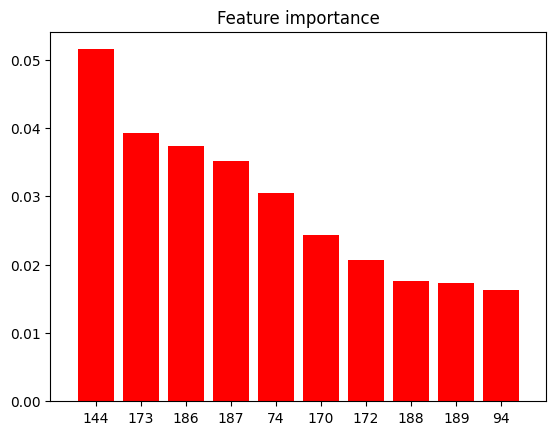

In [49]:
# Choose AICHA (here AAL2)
X=T1AICHA # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAICHA # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAICHA.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state= 32)

# Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# Random Forest on data
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='f1', cv=5)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test, y_test.ravel()))


best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 68
Best Validation Score: 0.8129521016617792
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 30}
Random Forest test score : 0.7653061224489796
Feature ranking:
1. feature 3 representing Right Amygdala                         (0.101725)
2. feature 0 representing Left Hippocampus                       (0.074030)
3. feature 2 representing Left Amygdala                          (0.067572)
4. feature 1 representing Right Hippocampus                      (0.042485)
5. feature 12 representing Left Inferior Middle Temporal Gyri     (0.038188)
6. feature 8 representing Left Ambient and Parahippocampus Gyri  (0.032507)
7. feature 47 representing Right Lateral Temporal Ventricle       (0.028251)
8. feature 46 representing Left Lateral Temporal Ventricle        (0.026204)
9. feature 44 representing Left Corpus Callosum                   (0.022658)
10. feature 64 repr

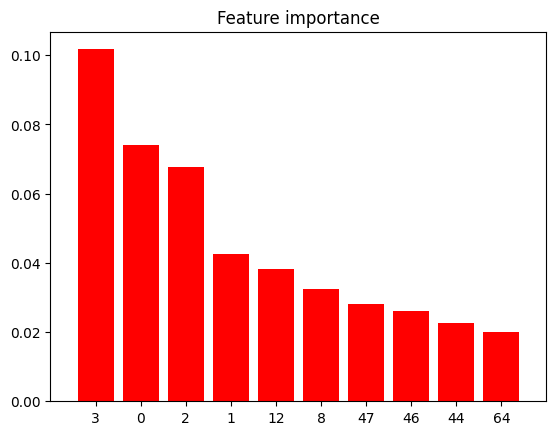

In [48]:
# Choose AICHA (here AAL2)
X=T1HAMMERS # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsHAMMERS # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasHAMMERS.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state= 53)

# Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# Random Forest on data
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='f1', cv=5)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test, y_test.ravel()))


best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

With this Atlas, the Hippocampus and Amygdala are the most important features as shown in the article and as we found with the AAL2 atlas.